## Import Library

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns',100)
pd.set_option('Display.max_rows',100)

## Import Dataset

In [13]:
# Read csv file
path    = "../../final_assignment_public/Telecom_customer_churn.csv"
df      = pd.read_csv( path )

print( 'df:\n{} rows × {} columns\n'.format( df.shape[0], df.shape[1] ) )

df:
100000 rows × 100 columns



In [14]:
# Read csv file
path = '../csv/f_imp_core.csv'
df_feature = pd.read_csv( path, index_col=0 )

print( 'df:\n{} rows × {} columns\n'.format( df_feature.shape[0], df_feature.shape[1] ) )

df:
22 rows × 1 columns



In [15]:
# 重要度が高い22種類のカラムだけ取得
df_core = df[df_feature['feature']]
df_core['churn'] = df['churn']
df_core

,eqpdays,months,change_mou,mou_Mean,totmrc_Mean,hnd_price,avgqty,lor,mou_cvce_Mean,change_rev,Customer_ID,totcalls,avg3mou,crclscod,refurb_new,hnd_webcap,avgrev,ovrmou_Mean,drop_vce_Mean,phones,ovrrev_Mean,mouiwylisv_Mean,churn
0,361.0,61,-157.25,219.25,22.500,149.98999,32.69,15.0,90.643333,-18.9975,1000001,1652,272,A,N,WCMB,29.66,0.00,0.666667,2.0,0.0,0.000000,1
1,240.0,56,532.25,482.75,37.425,NaN,265.89,1.0,189.396667,50.9875,1000002,14654,305,EA,N,WC,51.53,22.75,8.333333,7.0,9.1,3.696667,0
2,1504.0,58,-4.25,10.25,16.990,29.98999,140.86,7.0,5.426667,0.0000,1000003,7903,12,C,N,NaN,34.54,0.00,0.333333,2.0,0.0,0.000000,1
3,1812.0,60,-1.50,7.50,38.000,29.98999,30.81,6.0,8.410000,0.0000,1000004,1502,8,B,N,NaN,40.45,0.00,0.000000,1.0,0.0,0.000000,0
4,434.0,57,38.50,570.50,71.980,149.98999,79.50,5.0,285.233333,0.0000,1000005,4485,558,A,N,WCMB,38.69,0.00,9.666667,6.0,0.0,0.366667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,773.0,25,NaN,NaN,NaN,29.98999,178.62,15.0,94.866667,NaN,1099996,3771,410,B,N,WC,74.34,NaN,2.000000,1.0,NaN,0.000000,1
99996,835.0,27,NaN,NaN,NaN,29.98999,181.45,9.0,100.760000,NaN,1099997,3675,382,CY,N,WC,72.59,NaN,3.000000,1.0,NaN,0.000000,0
99997,433.0,31,NaN,NaN,NaN,199.98999,65.16,NaN,0.000000,NaN,1099998,1271,662,DA,N,WCMB,55.58,NaN,0.000000,2.0,NaN,0.000000,0
99998,75.0,25,NaN,NaN,NaN,149.98999,472.43,NaN,564.233333,NaN,1099999,10082,1031,EA,N,WCMB,123.49,NaN,18.666667,7.0,NaN,32.883333,0


## Data Preprocessing

### Categorical data

In [16]:
# カテゴリカル変数を表示
x_cat = df_core[df_core.select_dtypes( include=object ).columns].columns

# カテゴリカル変数を落とす(理解不能なため)
df_core = df_core.drop( columns=x_cat )

### Numerical data

In [17]:
def check_null( _df ):
    print( _df.isnull().sum() )

In [18]:
# 欠損が多いカラムを落とす
df_core = df_core.drop( columns='lor' )

In [19]:
# 不要なカラム(groupbyの結果，解約者と非解約者で差がないデータ)を落とす
df_core = df_core[ ['churn', 'eqpdays', 'change_mou', 'hnd_price', 'change_rev'] ]

In [20]:
# 欠損値を埋める
df_core['eqpdays']      = df_core['eqpdays'].fillna( df_core['eqpdays'].median() )
df_core['change_mou']   = df_core['change_mou'].fillna( df_core['change_mou'].median() )
df_core['hnd_price']    = df_core['hnd_price'].fillna( df_core['hnd_price'].median() )
df_core['change_rev']   = df_core['change_rev'].fillna( df_core['change_rev'].median() )

check_null( df_core )

churn         0
eqpdays       0
change_mou    0
mou_Mean      0
hnd_price     0
change_rev    0
dtype: int64


## EDA

### 残った4種類のデータ
|  重要度  |  カラム名  |  内容  |  分類  |
| ---- | ---- | ---- | ---- |
|  1  |  eqpdays  |  現在の端末の使用日数  |  使用日数  |
|  2  |  change_mou  |  過去3か月の毎月の平均使用時間の変化率(%)  |  使用時間  |
|  3  |  hnd_price  |  現在の携帯電話の料金  |  料金  |
|  4 |  change_rev  |  過去3か月の毎月の平均収入の変化率(%)  |  収入  |

### 解約者の特徴を分析する

In [ ]:
# 解約者と非解約者で，明らかに差がありそうなデータを探す
for column_name in df_core.columns:
    print( '{}\n'.format( df_core.groupby('churn')[column_name].mean() ) )

In [ ]:
# 解約者と非解約者で，明らかに差がありそうなデータを探す
for column_name in df_core.columns:
    print( '{}\n'.format( df_core.groupby('churn')[column_name].median() ) )

In [ ]:
# 解約者と非解約者で，明らかに差がありそうなデータを探す
for column_name in df_core.columns:
    print( '{}\n'.format( df_core.groupby('churn')[column_name].std() ) )

In [57]:
def plot( _y, _ylabel ):
    plt.rcParams["figure.figsize"] = (10, 10)
    # plt.title( 'Cumulative Feature Importance', fontsize=24 )

    # parameters
    x = [0, 1]
    bar_width = 0.5
    line_width = 0.5

    plt.bar( x[0], _y[0], bar_width, edgecolor='black', linewidth=line_width )
    plt.bar( x[1], _y[1], bar_width, edgecolor='black', linewidth=line_width )

    plt.xticks( [0, 1], fontsize=20 )
    plt.yticks( fontsize=20 )
    plt.xlabel( 'churn', fontsize=24 )
    plt.ylabel( _ylabel, fontsize=24 )
    plt.show()

#### 1. eqpday(現在の端末の使用日数)

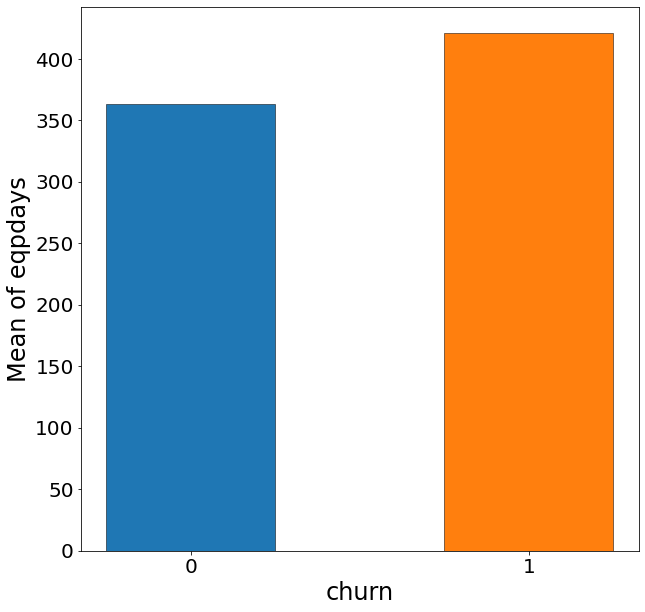

In [58]:
plot( df_core.groupby('churn')['eqpdays'].mean(), 'Mean of eqpdays' )

#### 2. change_mou(過去3か月の月間平均使用時間の変化率(%))

In [59]:
# 平均と標準偏差を計算
change_mou_mean = df_core['change_mou'].mean()
change_mou_std = df_core['change_mou'].std()

# 閾値を計算
change_mou_th_upper = change_mou_mean + 2*change_mou_std
change_mou_th_lower = change_mou_mean - 2*change_mou_std

# 外れ値を除去
df_change_mou = df_core[ (df_core['change_mou'] < change_mou_th_upper) & (df_core['change_mou'] > change_mou_th_lower) ]
df_change_mou = df_change_mou[ ['change_mou', 'churn'] ]

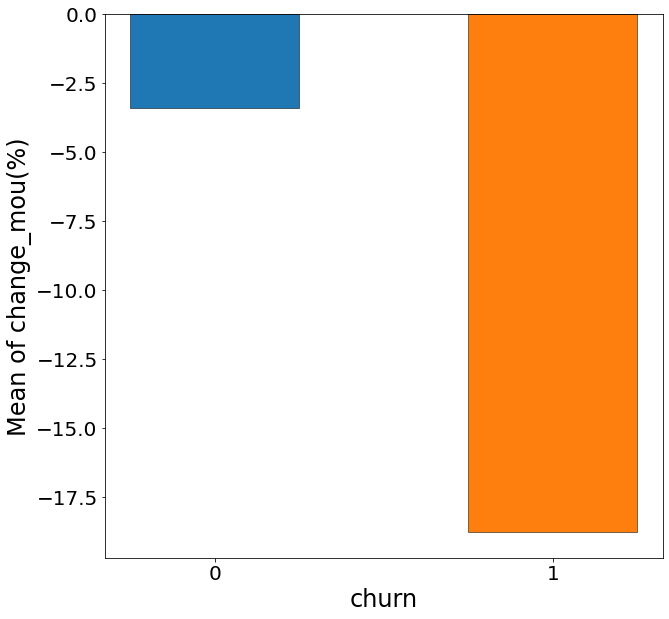

In [60]:
# plot( df_core.groupby('churn')['change_mou'].mean(), 'Mean of change_mou(%)' )
plot( df_change_mou.groupby('churn')['change_mou'].mean(), 'Mean of change_mou(%)' )

#### 3. hnd_price(現在の携帯電話の価格)

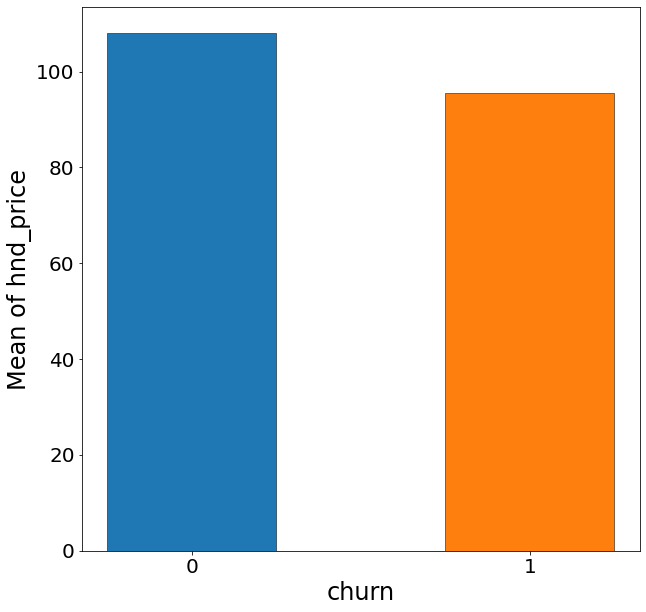

In [66]:
plot( df_core.groupby('churn')['hnd_price'].mean(), 'Mean of hnd_price' )

#### 4. change_rev(過去3か月間の月間平均収入の変化率(%))

In [62]:
# 平均と標準偏差を計算
change_rev_mean = df_core['change_rev'].mean()
change_rev_std = df_core['change_rev'].std()

# 閾値を計算
change_rev_th_upper = change_rev_mean + 2*change_rev_std
change_rev_th_lower = change_rev_mean - 2*change_rev_std

# 外れ値を除去
df_change_rev = df_core[ (df_core['change_rev'] < change_rev_th_upper) & (df_core['change_rev'] > change_rev_th_lower) ]
df_change_rev = df_change_rev[ ['change_rev', 'churn'] ]

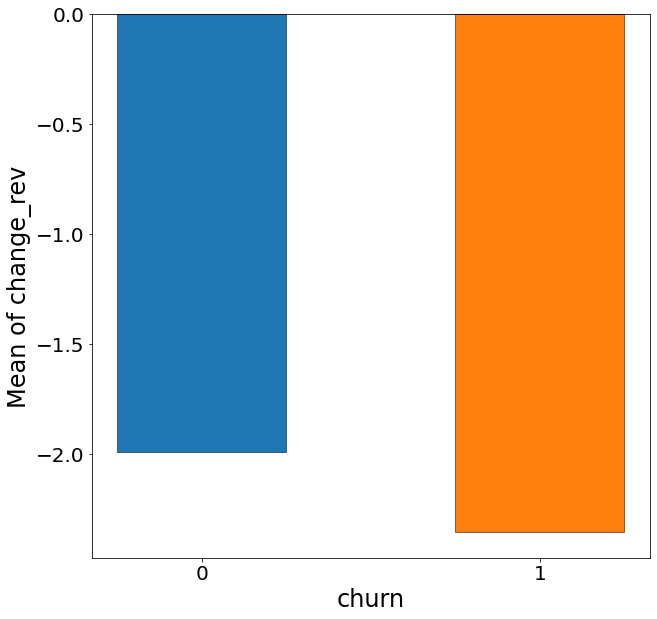

In [63]:
# plot( df_core.groupby('churn')['change_rev'].mean(), 'Mean of change_rev' )
plot( df_change_rev.groupby('churn')['change_rev'].mean(), 'Mean of change_rev' )

## Train Test Split

In [ ]:
# churnを目的変数に設定
y_train = df['churn']

# 目的変数のみ落とす
X_train = df.drop( columns=['churn'] )

In [ ]:
# LightGBM model
model_lgbm = LGBMClassifier(
        boosting_type='gbdt', 
        class_weight='balanced',
        reg_lambda=1.1564659040946654, 
        reg_alpha=9.90877329623665,
        colsample_bytree=0.5034991685866442, 
        subsample=0.6055998601661783, 
        max_depth=5,
        min_child_weight=39.72586351155486, 
        learning_rate=0.0732489659779158,
        num_threads=1 )

In [ ]:
# model_lgbm.fit( train_df[x_calls], train_df['TARGET'] )
model_lgbm.fit( X_train, y_train )

In [ ]:
lgbm.plot_importance( model_lgbm, importance_type="gain", max_num_features=100, figsize=(10, 20) )

In [ ]:
f_name = model_lgbm.feature_name_

# f_importance = model_lgbm.feature_importances_
f_importance = model_lgbm.booster_.feature_importance( importance_type='gain' )
f_importance = f_importance / np.sum( f_importance )

df_importance = pd.DataFrame( {'feature':f_name, 'importance':f_importance} )
df_importance = df_importance.sort_values('importance', ascending=False)

# インデックスを振り直す
df_importance = df_importance.reset_index()

display( df_importance )